# Generating Dataset

In [2]:


"""import cv2

cap = cv2.VideoCapture(0)

count1 = 100
count2 = 100
count3 = 100
count4 = 100
while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('a')):
        count1 += 1
        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('b')):
        count2 += 1
        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count3 += 1
        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('d')):
        count4 += 1
        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break
"""

# Save Files in CSV

In [30]:
import os
import csv
from PIL import Image
import pillow_heif

# Ensure pillow-heif is installed
# pip install pillow pillow-heif

# Base directory where the dataset is stored
base_dir = "dataset"
# Output CSV file
output_csv = "images.csv"

def convert_heic_to_jpg(file_path):
    """
    Converts a HEIC image to JPG, replaces the original file, and returns the new file path.
    """
    heif_file = pillow_heif.read_heif(file_path)
    image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw")

    # Replace the original file by saving as JPG
    new_file_path = os.path.splitext(file_path)[0] + ".jpg"
    image.save(new_file_path, "JPEG")

    # Delete the original HEIC file
    os.remove(file_path)

    return new_file_path

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the headers
    writer.writerow(["Path", "Label"])

    # Walk through the dataset directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        # Ensure it's a folder
        if os.path.isdir(folder_path):
            # Assign labels based on folder name
            label = folder_name
            if folder_name == "gesture_1":
                label = "scissor"
            elif folder_name == "gesture_2":
                label = "rock"
            elif folder_name == "gesture_3":
                label = "paper"
            elif folder_name == "gesture_4":
                label = "nogesture"

            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Convert HEIC to JPG and replace the file
                if file_name.lower().endswith(".heic"):
                    file_path = convert_heic_to_jpg(file_path)
                    writer.writerow([file_path, label])
                # Ensure it's an image file
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Write the relative path and label to the CSV
                    writer.writerow([file_path, label])

print(f"Images and labels have been saved to {output_csv}")


Images and labels have been saved to images.csv


# Initialize functions

In [31]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        #self.class_to_idx = {cls: idx for idx, cls in enumerate(
        #    ['checazzo', 'peace', 'nice', 'nogesture'])}
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['scissor', 'rock', 'paper', 'nogesture'])}
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [32]:
import cv2
import numpy as np
import random


class CustomTransform:
    def __init__(self):
        self.counter_rotation = 0
        self.counter_flipping = 0
        self.counter_blurring = 0
        self.counter_sharpening = 0
        self.counter_noise = 0
        self.counter_scale = 0

    def random_rotation(self, image):
        """Rotate the image by a random angle (90, 180, or 270 degrees)."""
        _, rows, cols = image.shape
        angle = random.choice([90, 180, 270])  # Randomly choose an angle
        M = cv2.getRotationMatrix2D((cols / 2.0, rows / 2.0), angle, 1)
        rotated = cv2.warpAffine(image.transpose(1, 2, 0), M, (cols, rows))  # Convert from (C, H, W) to (H, W, C)

        rotated = rotated.transpose(2, 0, 1)  # Convert back to (C, H, W)
        self.counter_rotation += 1
        return rotated

    def random_flipping(self, image):
        """Flip the image randomly."""
        flip_code = random.choice([-1, 0, 1])  # -1: both axes, 0: vertical, 1: horizontal
        flipped = cv2.flip(image.transpose(1, 2, 0), flip_code)  # Convert from (C, H, W) to (H, W, C)

        flipped = flipped.transpose(2, 0, 1)  # Convert back to (C, H, W)
        self.counter_flipping += 1
        return flipped

    def random_blurring(self, image):
        """Apply random Gaussian blur."""
        kernel_size = random.choice([3, 5, 7])  # Use smaller kernel sizes
        blurred = cv2.GaussianBlur(image.transpose(1, 2, 0), (kernel_size, kernel_size), 0)  # Convert to (H, W, C)

        blurred = blurred.transpose(2, 0, 1)  # Convert back to (C, H, W)
        self.counter_blurring += 1
        return blurred

    def random_sharpening(self, image):
        """Apply a sharpening kernel only on the luminance channel (L) to avoid excessive color distortion."""
        
        image_lab = cv2.cvtColor(image.transpose(1, 2, 0), cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(image_lab)
        
        kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]])

        sharpened_L = cv2.filter2D(L, -1, kernel)
        image_lab_sharpened = cv2.merge([sharpened_L, A, B])      
        sharpened_rgb = cv2.cvtColor(image_lab_sharpened, cv2.COLOR_LAB2RGB)
    
        sharpened_rgb = sharpened_rgb.transpose(2, 0, 1)
        
        self.counter_sharpening += 1
        return sharpened_rgb

    def add_random_noise(self, image):
        """Add random Gaussian noise."""
        # Ensure the image is in float32 format and normalized
        image = (image - image.min()) / (image.max() - image.min())
        _, row, col = image.shape

        # Gaussian noise parameters
        mean = 0
        var = random.uniform(0.001, 0.005)  # Larger variance for visible noise
        sigma = var ** 0.5

        # Generate Gaussian noise of shape (C, H, W), matching the image's shape
        gauss = np.random.normal(mean, sigma, (3, row, col))  # (C, H, W) for RGB image

        # Add the Gaussian noise to the image
        noisy = image + gauss  # Add noise directly to each channel

        # Clip the values to stay within [0, 1], then scale back to [0, 255]
        noisy = np.clip(noisy, 0, 1) * 255
        noisy = noisy.astype(np.uint8)

        self.counter_noise += 1
        return noisy



    def random_scaling(self, image):
        scaling_zoom_factor = random.uniform(1.1, 1.3)
        
        zoomed = cv2.resize(image.transpose(1, 2, 0), None, fx=scaling_zoom_factor, fy=scaling_zoom_factor, interpolation=cv2.INTER_LINEAR)

        center_x, center_y = zoomed.shape[1] // 2, zoomed.shape[0] // 2
        crop_size = 128

        random_scale = zoomed[center_y - crop_size // 2: center_y + crop_size // 2,
                                center_x - crop_size // 2: center_x + crop_size // 2]

        random_scale = random_scale.transpose(2, 0, 1)
        self.counter_scale += 1
        return random_scale

    def __call__(self, image):
        """Apply a random combination of augmentations."""
        augmentations = [
            self.random_rotation,
            self.random_flipping,
            self.random_blurring,
            self.random_sharpening,
            self.add_random_noise,
        ]
        random.shuffle(augmentations)

        # Apply the first transformation from the shuffled list
        transformed = augmentations[0](image)
        # Apply scaling to ensure the final output is standardized
        scaled_transformed = self.random_scaling(transformed)

        return (
            transformed,
            scaled_transformed,
            self.counter_rotation,
            self.counter_flipping,
            self.counter_blurring,
            self.counter_sharpening,
            self.counter_noise,
            self.counter_scale,
        )


In [33]:
import os
import numpy as np
import torch
from PIL import Image
import random
import shutil

# Augment Dataset with Labels and Save Images
def augment_and_add_to_dataset(dataset, transform, num_augmentations=1, save_dir='augmented_dataset'):
    """
    Augment the dataset by applying transformations to each image
    and appending the augmented images with the same labels to the dataset.
    Saves the augmented images in class-specific directories.

    Args:
        dataset: The original dataset (CustomImageDataset or similar).
        transform: The transformation class with custom augmentation functions.
        num_augmentations: Number of augmented versions to create per image.
        save_dir: Root directory where augmented images will be saved.

    Returns:
        Augmented dataset (list of tuples with image tensor and label).
    """
    counter_rotation = 0
    counter_flipping = 0
    counter_blurring = 0
    counter_sharpening = 0
    counter_noise = 0
    counter_scaling = 0



    """   # Clear the directory if it exists
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete everything inside the folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the base directory for augmented dataset
    """
    augmented_data = []

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Convert tensor back to numpy for transformation
        original_image = image.squeeze(0).numpy()
        #print(original_image.shape)
        # Add the original image and label
        augmented_data.append((image, label))

        # Create class-specific directory if it doesn't exist
        class_dir = os.path.join(save_dir, f'class_{label}')
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the original image
        save_image(original_image, class_dir, num_augmentations, 'original')

        # Create augmented versions and save them
        for i in range(num_augmentations):
            augmented_image, scaled, counter_rotation,counter_flipping, counter_blurring, counter_sharpening, counter_noise, counter_scaling = transform(original_image)
            augmented_image_tensor = torch.tensor(augmented_image)
            scaled_tensor = torch.tensor(scaled)
            # Save augmented image
            save_image(augmented_image, class_dir,num_augmentations, f'aug_{i + 1}_{label}')
            save_image(scaled, class_dir,num_augmentations, f'scal_{i + 1}_{label}')

            augmented_data.append((augmented_image_tensor, label))
            augmented_data.append((scaled_tensor, label))



     # Apply only the first transformation from the shuffled list
    print("Counter rotation: ", counter_rotation)
    print("Counter flipping: ", counter_flipping)
    print("Counter blurring: ", counter_blurring)
    print("Counter sharpening: ", counter_sharpening)
    print("Counter noise: ", counter_noise)
    print("Counter scaling: ", counter_scaling)
    return augmented_data


def save_image(image, class_dir, num_augmentations, suffix):
    """
    Save the image to the specified directory with the given suffix.
    """
    
    # If the image has shape (channels, height, width), transpose to (height, width, channels)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Convert to uint8 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    #print(f"Processed image shape: {image.shape}, dtype: {image.dtype}")

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image)

    # Create a unique filename for each image
    filename = f"{suffix}_{random.randint(0, 1000)}.jpg"  # Adding randomness to avoid overwriting

    # Save the image in the class directory
    pil_image.save(os.path.join(class_dir, filename))





In [34]:
seed = 42
generator = torch.Generator().manual_seed(seed)

BATCH_SIZE = 64


current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


#classes = ('checazzo', 'peace', 'nice', 'nogesture')

classes = ('scissor', 'rock', 'paper', 'nogesture')
# Set up transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the image to 32x32
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    ])

# Instantiate custom transformation
custom_transform_100 = CustomTransform()
custom_transform_200 = CustomTransform()
custom_transform_300 = CustomTransform()

# Create dataset
original_dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(f"Original dataset size: {len(original_dataset)}")
# Split dataset into 80% train and 20% test
train_size_original = int(0.8 * len(original_dataset))
test_size_original = len(original_dataset) - train_size_original
train_set_original, test_set_original = random_split(original_dataset, [train_size_original, test_size_original],generator=generator)
# Create DataLoaders
train_loader_original = DataLoader(train_set_original, batch_size=BATCH_SIZE, shuffle=True)
test_loader_original = DataLoader(test_set_original, batch_size=BATCH_SIZE, shuffle=False)


# Augment the dataset by 100 images per class
num_augmentations_100 = 1  # Number of augmented versions per original image
dataset_100 = augment_and_add_to_dataset(train_set_original, custom_transform_100, num_augmentations_100, save_dir='augmented_rps_100')
print(f"Augmented dataset size: {len(dataset_100)}")
# Split dataset into 80% train and 20% 
train_size_100 = int(0.8 * len(dataset_100))
test_size_100 = len(dataset_100) - train_size_100
#train_set_100, test_set_100 = random_split(dataset_100, [train_size_100, test_size_100],generator=generator)
# Create DataLoaders
train_loader_100 = DataLoader(dataset_100, batch_size=BATCH_SIZE, shuffle=True)
#test_loader_100 = DataLoader(test_set_100, batch_size=32, shuffle=False)

# Augment the dataset by 200 images per class
num_augmentations_200 = 2  # Number of augmented versions per original image
dataset_200 = augment_and_add_to_dataset(train_set_original, custom_transform_200, num_augmentations_200, save_dir='augmented_rps_200')
print(f"Augmented dataset size: {len(dataset_200)}")
# Split dataset into 80% train and 20% test
train_size_200 = int(0.8 * len(dataset_200))
test_size_200 = len(dataset_200) - train_size_200
#train_set_200, test_set_200 = random_split(dataset_200, [train_size_200, test_size_200],generator=generator)
# Create DataLoaders
train_loader_200 = DataLoader(dataset_200, batch_size=BATCH_SIZE, shuffle=True)
#test_loader_200 = DataLoader(test_set_200, batch_size=32, shuffle=False)


# Augment the dataset by 300 images per class
num_augmentations_300 = 3  # Number of augmented versions per original image
dataset_300 = augment_and_add_to_dataset(train_set_original, custom_transform_300, num_augmentations_300, save_dir='augmented_rps_300')
print(f"Augmented dataset size: {len(dataset_300)}")
# Split dataset into 80% train and 20% test
train_size_300 = int(0.8 * len(dataset_300))
test_size_300 = len(dataset_300) - train_size_300
#train_set_300, test_set_300 = random_split(dataset_300, [train_size_300, test_size_300],generator=generator)
# Create DataLoaders
train_loader_300 = DataLoader(dataset_300, batch_size=BATCH_SIZE, shuffle=True)
#test_loader_300 = DataLoader(test_set_300, batch_size=32, shuffle=False)



Current directory: c:\Users\julia\Documents\VC PS\Visual-Project
Original dataset size: 400
Counter rotation:  62
Counter flipping:  66
Counter blurring:  70
Counter sharpening:  58
Counter noise:  64
Counter scaling:  320
Augmented dataset size: 960
Counter rotation:  122
Counter flipping:  137
Counter blurring:  126
Counter sharpening:  126
Counter noise:  129
Counter scaling:  640
Augmented dataset size: 1600
Counter rotation:  185
Counter flipping:  185
Counter blurring:  231
Counter sharpening:  196
Counter noise:  163
Counter scaling:  960
Augmented dataset size: 2240


In [35]:
# Function to show images
"""def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()

    # Remove extra singleton dimensions (1, 1, 3, 32, 32) => (3, 32, 32)
    npimg = np.squeeze(npimg)  # Remove the extra singleton dimensions

    # If the image has 3 channels (RGB), we can directly display it
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (32, 32, 3) for RGB format

    plt.imshow(npimg)  # Show the image with RGB channels
    plt.show()
   """
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (if normalized with mean=0.5, std=0.5)
    npimg = img.numpy()

    # Remove extra singleton dimensions (e.g., (1, 1, 32, 32) -> (1, 32, 32))
    npimg = np.squeeze(npimg)

    if len(npimg.shape) == 2:  # If the image is 2D (grayscale)
        plt.imshow(npimg, cmap='gray')
    elif len(npimg.shape) == 3 and npimg.shape[0] == 3:  # If the image has 3 channels (RGB)
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (H, W, 3) for RGB
        plt.imshow(npimg)
    else:
        raise ValueError("Unexpected image shape: {}".format(npimg.shape))

    plt.axis('off')  # Optional: Turn off the axis
    plt.show()
 

# Get some random training images

#dataset_iter = iter(train_loader_original)
#images, labels = next(dataset_iter)

"""# Loop through each image in the batch
for i, image in enumerate(images):
    print(f"Image {i + 1}")
    imshow(image)
    print(f"Label: {classes[labels[i].item()]}")"""

'# Loop through each image in the batch\nfor i, image in enumerate(images):\n    print(f"Image {i + 1}")\n    imshow(image)\n    print(f"Label: {classes[labels[i].item()]}")'

# CNN

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = ((input_size - kernel_size + 2*padding) / stride) + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 128x128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=1) #output size = 124x124
        #self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1) #output size = 60*60
        #self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #output size = 30*30
        #self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1) #output size = 14*14
        #self.bn4 = nn.BatchNorm2d(64)
        #self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5) # tried with 0.7


        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 4) #4 output classes 3 gestures and 1 for no gesture

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # output size = 62*62
        x = self.pool(F.relu(self.conv2(x))) # output size = 30*30
        x = self.pool(F.relu(self.conv3(x))) #output size = 15*15
        x = self.pool(F.relu(self.conv4(x))) # output size = 7*7

        #x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #x = self.pool(F.relu(self.bn4(self.conv4(x))))

       # x = F.relu(self.conv5(x)) #output size = 8x8
       # x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64*7*7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [67]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 50

# Check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

print(device)


model_original = Net()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=LEARNING_RATE)
criterion_original = nn.CrossEntropyLoss()


model_100 = Net()
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=LEARNING_RATE)
criterion_100 = nn.CrossEntropyLoss()


model_200 = Net()
optimizer_200 = torch.optim.Adam(model_200.parameters(), lr=LEARNING_RATE)
criterion_200 = nn.CrossEntropyLoss()


model_300 = Net()
optimizer_300 = torch.optim.Adam(model_300.parameters(), lr=LEARNING_RATE)
criterion_300 = nn.CrossEntropyLoss()




print(model_original)


Using device: cpu
cpu
Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=Tr

In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
from torchsummary import summary

summary(model_original, (3, 128, 128)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             608
         MaxPool2d-2            [-1, 8, 63, 63]               0
            Conv2d-3           [-1, 16, 61, 61]           3,216
         MaxPool2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 30, 30]           4,640
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 14, 14]          32,832
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1000]       3,137,000
          Dropout-10                 [-1, 1000]               0
           Linear-11                  [-1, 512]         512,512
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [68]:

def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
        
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    print('Finished Training')
    return losses


Epoch 1, loss: 1.5214288234710693
Epoch 2, loss: 1.522853970527649
Epoch 3, loss: 1.5592228174209595
Epoch 4, loss: 1.440641713142395
Epoch 5, loss: 1.421225333213806
Epoch 6, loss: 1.41653892993927
Epoch 7, loss: 1.4259181499481202
Epoch 8, loss: 1.4327146053314208
Epoch 9, loss: 1.407452368736267
Epoch 10, loss: 1.4086806535720826
Epoch 11, loss: 1.404125452041626
Epoch 12, loss: 1.4106065273284911
Epoch 13, loss: 1.3974007606506347
Epoch 14, loss: 1.3873364448547363
Epoch 15, loss: 1.3923213720321654
Epoch 16, loss: 1.3756619215011596
Epoch 17, loss: 1.3837386608123778
Epoch 18, loss: 1.377182626724243
Epoch 19, loss: 1.3903816938400269
Epoch 20, loss: 1.3733177661895752
Epoch 21, loss: 1.3997284173965454
Epoch 22, loss: 1.3686893463134766
Epoch 23, loss: 1.384446120262146
Epoch 24, loss: 1.3452818870544434
Epoch 25, loss: 1.3600382089614869
Epoch 26, loss: 1.338434362411499
Epoch 27, loss: 1.3314867734909057
Epoch 28, loss: 1.3345648050308228
Epoch 29, loss: 1.352045202255249
Epoch

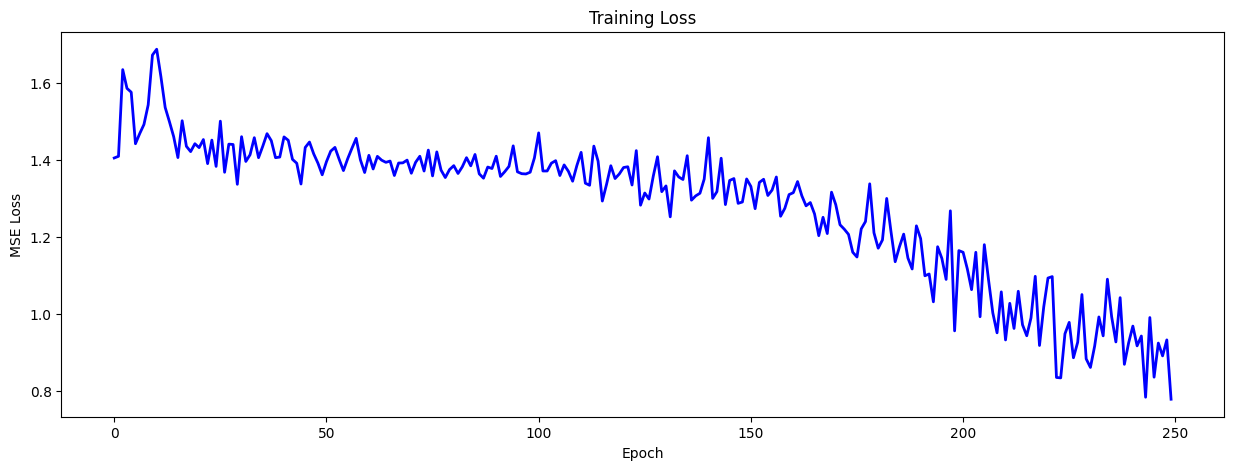

In [69]:
losses_original = train(model=model_original, train_loader=train_loader_original, optimizer=optimizer_original, criterion=criterion_original, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_original, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_original.pth'
torch.save(model_original.state_dict(), PATH)

Epoch 1, loss: 1.5457701524098715
Epoch 2, loss: 1.426489528020223
Epoch 3, loss: 1.3997541189193725
Epoch 4, loss: 1.3976122379302978
Epoch 5, loss: 1.3955076138178508
Epoch 6, loss: 1.3889001766840616
Epoch 7, loss: 1.3898749430974324
Epoch 8, loss: 1.4071035464604695
Epoch 9, loss: 1.3864983638127646
Epoch 10, loss: 1.3893775860468547
Epoch 11, loss: 1.377626935640971
Epoch 12, loss: 1.3756381352742513
Epoch 13, loss: 1.3816059907277425
Epoch 14, loss: 1.3766430536905925
Epoch 15, loss: 1.3772151072820027
Epoch 16, loss: 1.3826362848281861
Epoch 17, loss: 1.3688535849253336
Epoch 18, loss: 1.3749468564987182
Epoch 19, loss: 1.3739456176757812
Epoch 20, loss: 1.3780588547388712
Epoch 21, loss: 1.3744455973307292
Epoch 22, loss: 1.3640820423762003
Epoch 23, loss: 1.3741844018300375
Epoch 24, loss: 1.3666939576466879
Epoch 25, loss: 1.3760861476262412
Epoch 26, loss: 1.3749545653661093
Epoch 27, loss: 1.363421654701233
Epoch 28, loss: 1.369262146949768
Epoch 29, loss: 1.367296640078226

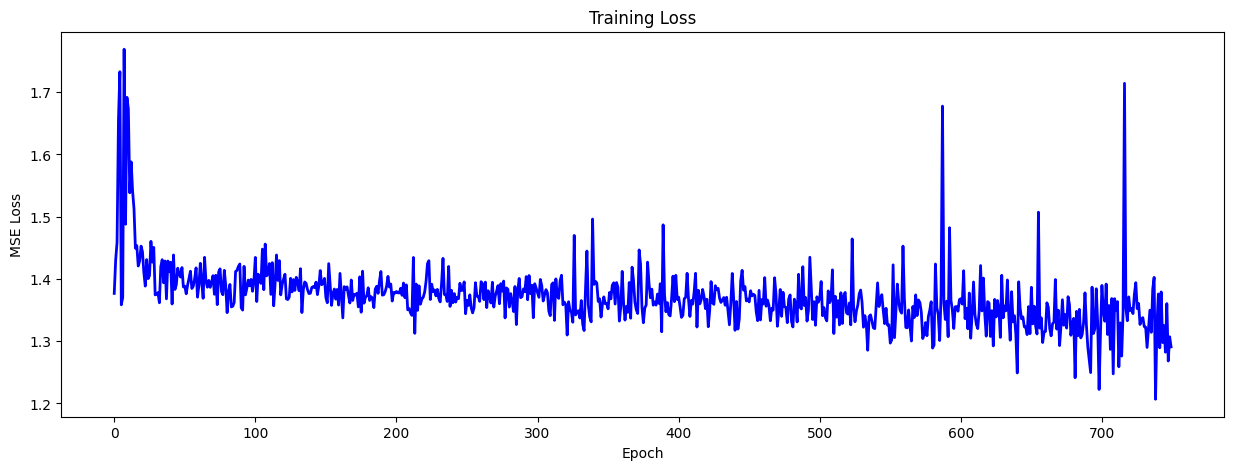

In [70]:
losses_100 = train(model=model_100, train_loader=train_loader_100, optimizer=optimizer_100, criterion=criterion_100, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_100, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_100.pth'
torch.save(model_100.state_dict(), PATH)

Epoch 1, loss: 1.540072979927063
Epoch 2, loss: 1.4218096828460693
Epoch 3, loss: 1.4074064874649048
Epoch 4, loss: 1.394868769645691
Epoch 5, loss: 1.4018404054641724
Epoch 6, loss: 1.3949469757080077
Epoch 7, loss: 1.391823091506958
Epoch 8, loss: 1.3870303630828857
Epoch 9, loss: 1.3887544393539428
Epoch 10, loss: 1.3901521396636962
Epoch 11, loss: 1.3910938549041747
Epoch 12, loss: 1.3877682161331177
Epoch 13, loss: 1.386184287071228
Epoch 14, loss: 1.386377730369568
Epoch 15, loss: 1.385523386001587
Epoch 16, loss: 1.3868243598937988
Epoch 17, loss: 1.3894917964935303
Epoch 18, loss: 1.3890420007705688
Epoch 19, loss: 1.385984215736389
Epoch 20, loss: 1.3855494022369386
Epoch 21, loss: 1.3912272214889527
Epoch 22, loss: 1.3860638046264648
Epoch 23, loss: 1.38229229927063
Epoch 24, loss: 1.3836096906661988
Epoch 25, loss: 1.3844709777832032
Epoch 26, loss: 1.3802661418914794
Epoch 27, loss: 1.3806090354919434
Epoch 28, loss: 1.3791313123703004
Epoch 29, loss: 1.3803961038589478
Epo

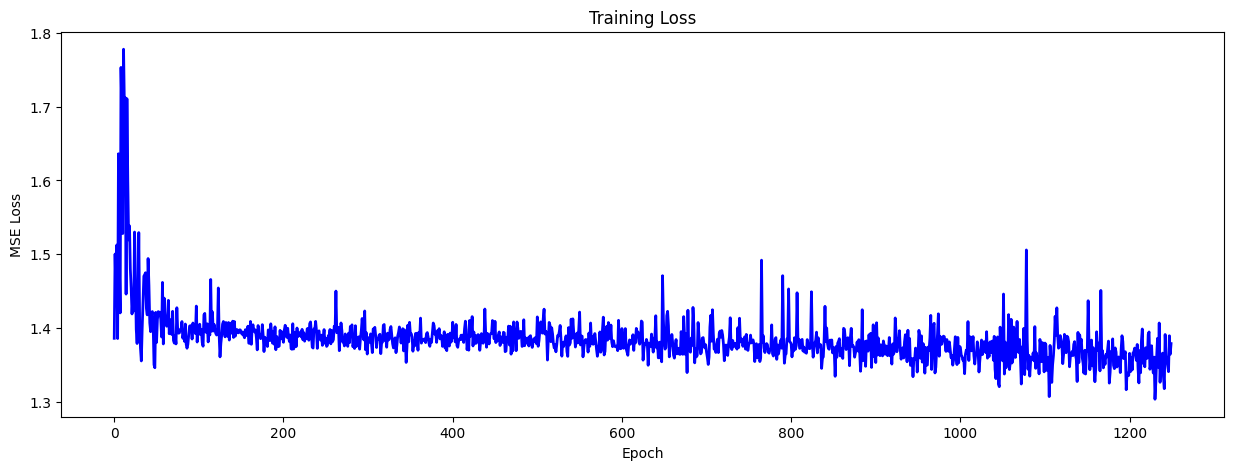

In [71]:
losses_200 = train(model=model_200, train_loader=train_loader_200, optimizer=optimizer_200, criterion=criterion_200, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_200, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_200.pth'
torch.save(model_200.state_dict(), PATH)

In [72]:
losses_300 = train(model=model_300, train_loader=train_loader_300, optimizer=optimizer_300, criterion=criterion_300, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_300, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_300.pth'
torch.save(model_300.state_dict(), PATH)

Epoch 1, loss: 1.4803342274257114
Epoch 2, loss: 1.4074057817459107
Epoch 3, loss: 1.397238084248134
Epoch 4, loss: 1.3932072264807565
Epoch 5, loss: 1.3884850536073958
Epoch 6, loss: 1.3814587490899222
Epoch 7, loss: 1.3830447878156389
Epoch 8, loss: 1.3828629050936019
Epoch 9, loss: 1.379708991731916
Epoch 10, loss: 1.380010325568063
Epoch 11, loss: 1.385879383768354
Epoch 12, loss: 1.3799830096108572


KeyboardInterrupt: 

C:\Users\julia\AppData\Local\Temp\ipykernel_9420\358853493.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_original.load_state_dict(torch.load('model_original.pth'

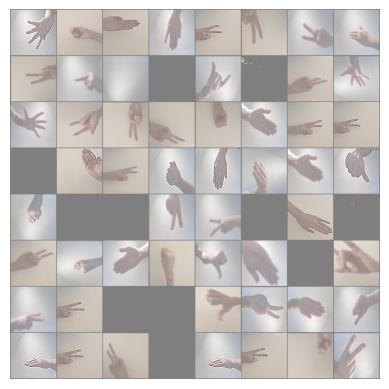

In [17]:
model_original.load_state_dict(torch.load('model_original.pth'))

# Check the testset
dataiter = iter(train_loader_300)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


# Resnet

In [18]:
from torchvision import models
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 4  # For CIFAR-10

# Load ResNet18
model_resnet = models.resnet18(pretrained=True).to(device)


# Verify the model
print(model_resnet)




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Prevent the trained weights from being modified
for name, param in model_resnet.named_parameters():
  if 'fc' not in name: # Adjust this condition to target specific layers if needed
    param.requires_grad = False


# Compute the input feature size for the first fc layer
num_ftrs_resnet = model_resnet.fc.in_features
print(num_ftrs_resnet)

# Create a new set of fc layers
classifier = [
    nn.Linear(in_features=num_ftrs_resnet, out_features=256).to(device),
    nn.ReLU(inplace=True).to(device),
    nn.Dropout(p=0.3, inplace=False).to(device),
    nn.Linear(in_features=256, out_features=4, bias=True).to(device)
]

model_resnet.fc = nn.Sequential(*classifier).to(device) # Replace the model classifier

512


In [20]:
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.01)

In [21]:
def train_resnet(model_resnet, train_loader, optimizer_resnet, criterion, n_epochs):
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
                    
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer_resnet.zero_grad()

            # forward + backward + optimize
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet.step()

            losses.append(loss.item())
            # print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")
    return losses 

In [22]:
# Check the accuracy of the finetuned network on the test set
def test_resnet(model_resnet, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model_resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images with ResNet and a slightly modified classifier: %d %%' % (
        100 * correct / total))

Epoch 1, loss: 4.926714241504669
Epoch 2, loss: 2.8485654294490814
Epoch 3, loss: 1.2726985812187195
Epoch 4, loss: 0.9636919349431992
Epoch 5, loss: 0.8655022084712982
Epoch 6, loss: 0.6478682458400726
Epoch 7, loss: 0.5396600365638733
Epoch 8, loss: 0.4543187841773033
Epoch 9, loss: 0.3306456431746483
Epoch 10, loss: 0.3198542818427086
Epoch 11, loss: 0.24514973536133766
Epoch 12, loss: 0.19940043613314629
Epoch 13, loss: 0.13150962628424168
Epoch 14, loss: 0.1676632333546877
Epoch 15, loss: 0.11301599442958832
Epoch 16, loss: 0.09358850121498108
Epoch 17, loss: 0.09607403911650181
Epoch 18, loss: 0.11235234700143337
Epoch 19, loss: 0.09279998391866684
Epoch 20, loss: 0.12516262009739876
Epoch 21, loss: 0.08843923639506102
Epoch 22, loss: 0.07772128842771053
Epoch 23, loss: 0.0809614323079586
Epoch 24, loss: 0.041729352436959743
Epoch 25, loss: 0.05691531230695546
Epoch 26, loss: 0.08128785341978073
Epoch 27, loss: 0.07562038954347372
Epoch 28, loss: 0.0665743350982666
Epoch 29, loss

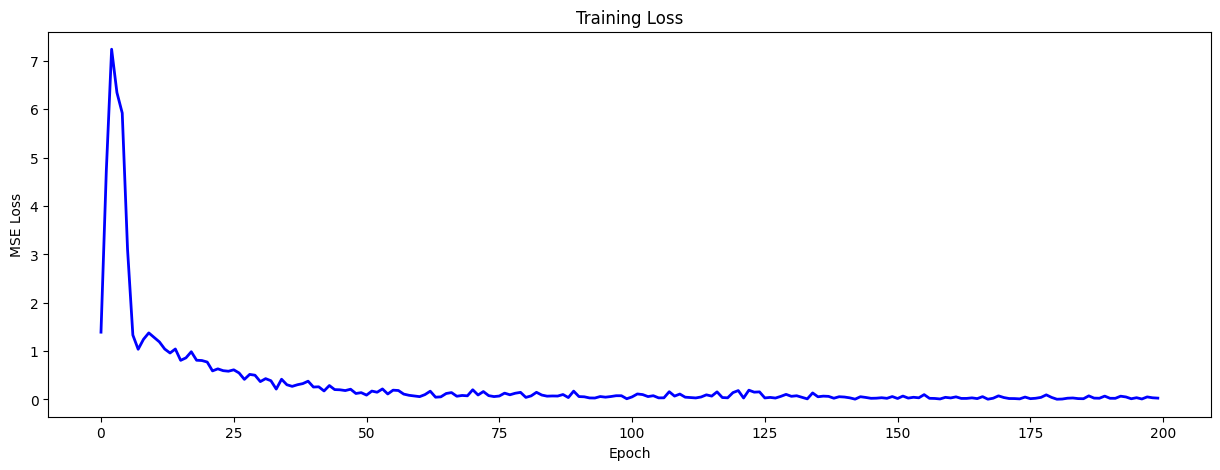

In [23]:
losses_resnet = train_resnet(model_resnet, train_loader_300, optimizer_resnet, criterion_resnet, n_epochs=50)


plt.figure(figsize=(15, 5))
plt.plot(losses_resnet, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './resnet.pth'
torch.save(model_resnet.state_dict(), PATH)

In [24]:
# load the model 
model_resnet.load_state_dict(torch.load('resnet.pth')) 

# Test the ResNet model
test_resnet(model_resnet, test_loader_original)

C:\Users\gabri\AppData\Local\Temp\ipykernel_24292\439065298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load('resnet.pth'))


Accuracy of the network on test images with ResNet and a slightly modified classifier: 79 %


# Evaluation

In [56]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [57]:
# Calculate the overall accuracy
print("Model original")
overall_accuracy_original = test_accuracy(model_original, test_loader_original, device=device)

print("\nModel 100")
overall_accuracy_100 = test_accuracy(model_100, test_loader_original, device=device)

print("\nModel 200")
overall_accuracy_200 = test_accuracy(model_200, test_loader_original, device=device)

print("\nModel 300")
overall_accuracy_300 = test_accuracy(model_300, test_loader_original, device=device)

print("\nResNet")
overall_accuracy_resnet = test_accuracy(model_resnet, test_loader_original, device=device)


Model original
Accuracy of the network on the test images: 66.25 %

Model 100
Accuracy of the network on the test images: 71.25 %

Model 200
Accuracy of the network on the test images: 23.75 %

Model 300
Accuracy of the network on the test images: 77.50 %

ResNet


NameError: name 'model_resnet' is not defined

In [59]:
def accuracy(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [60]:
# Call the accuracy function
print("Model original")
class_accuracies = accuracy(model_original, test_loader_original, classes, device=device)

print("\nModel 100")
class_accuracies_100 = accuracy(model_100, test_loader_original, classes, device=device)

print("\nModel 200")
class_accuracies_200 = accuracy(model_200, test_loader_original, classes, device=device)

print("\nModel 300")
class_accuracies_300 = accuracy(model_300, test_loader_original, classes, device=device)

print("\nModel Resnet and Augmentation")
class_accuracies_resnet = accuracy(model_resnet, test_loader_original, classes, device=device)


Model original
Accuracy of scissor : 72.73 %
Accuracy of rock : 26.32 %
Accuracy of paper : 65.00 %
Accuracy of nogesture : 100.00 %

Model 100
Accuracy of scissor : 77.27 %
Accuracy of rock : 78.95 %
Accuracy of paper : 55.00 %
Accuracy of nogesture : 73.68 %

Model 200
Accuracy of scissor : 0.00 %
Accuracy of rock : 100.00 %
Accuracy of paper : 0.00 %
Accuracy of nogesture : 0.00 %

Model 300
Accuracy of scissor : 81.82 %
Accuracy of rock : 73.68 %
Accuracy of paper : 65.00 %
Accuracy of nogesture : 89.47 %

Model Resnet and Augmentation


NameError: name 'model_resnet' is not defined

In [24]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred, average='weighted'):
    """
    Calculate the F1 score for a classification problem.

    Parameters:
    - y_true: List or array of true class labels
    - y_pred: List or array of predicted class labels
    - average: The averaging method ('micro', 'macro', or 'weighted')

    Returns:
    - f1: F1 score (float)
    """
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"F1 Score ({average}): {f1:.2f}")
    return f1


ModuleNotFoundError: No module named 'sklearn'

In [30]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total

    #Compute F1 score
    f1 = calculate_f1_score(all_labels, all_preds, average=average)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix, f1


Model original
F1 Score (weighted): 0.08
Accuracy of the network on the test set: 22.03%


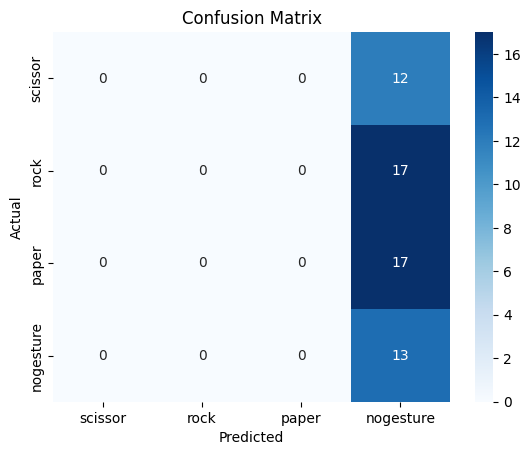


Model 100
F1 Score (weighted): 0.24
Accuracy of the network on the test set: 35.59%


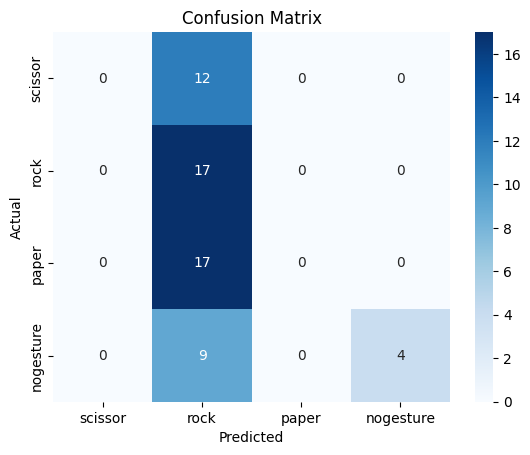


Model 200
F1 Score (weighted): 0.35
Accuracy of the network on the test set: 45.76%


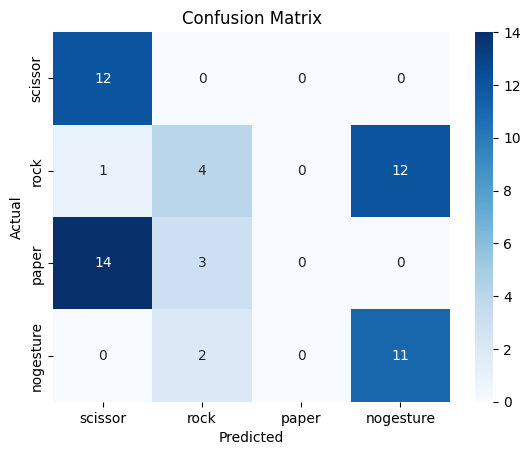


Model 300
F1 Score (weighted): 0.50
Accuracy of the network on the test set: 57.63%


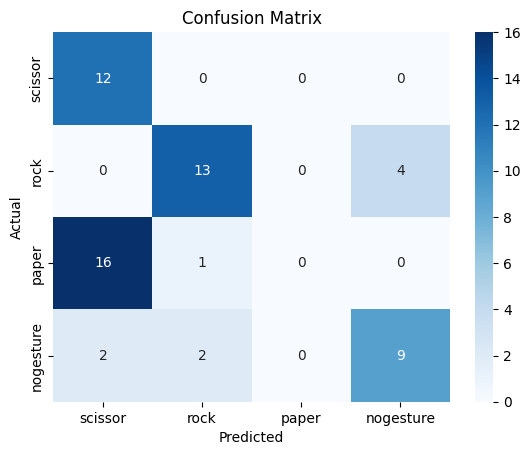


Model Resnet
F1 Score (weighted): 0.85
Accuracy of the network on the test set: 84.75%


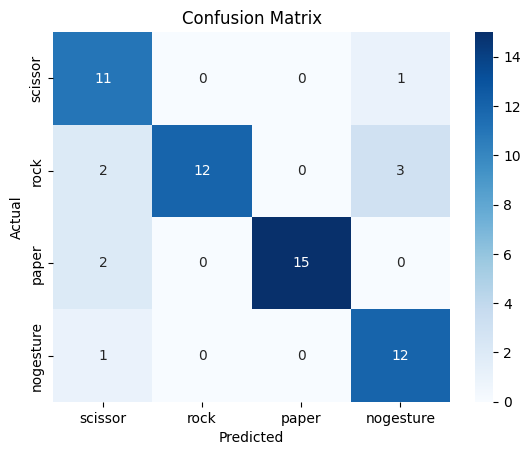

In [31]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
print("Model original")
overall_accuracy, confusion_mat, f1 = evaluate_model(model_original, test_loader_original, label_map, device=device,average='weighted')

print("\nModel 100")
overall_accuracy_100, confusion_mat_100, f1_100 = evaluate_model(model_100, test_loader_original, label_map, device=device,average='weighted')

print("\nModel 200")
overall_accuracy_200, confusion_mat_200, f1_200 = evaluate_model(model_200, test_loader_original, label_map, device=device,average='weighted')

print("\nModel 300")
overall_accuracy_300, confusion_mat_300, f1_300 = evaluate_model(model_300, test_loader_original, label_map, device=device,average='weighted')

print("\nModel Resnet")
overall_accuracy_resnet, confusion_mat_resnet, f1_resnet = evaluate_model(model_resnet, test_loader_original, label_map, device=device,average='weighted')


# Demo

In [1]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load your PyTorch model
# Load ResNet18
model_resnet = models.resnet18(pretrained=True).to(device)


# Prevent the trained weights from being modified
for name, param in model_resnet.named_parameters():
  if 'fc' not in name: # Adjust this condition to target specific layers if needed
    param.requires_grad = False


# Compute the input feature size for the first fc layer
num_ftrs_resnet = model_resnet.fc.in_features
print(num_ftrs_resnet)

# Create a new set of fc layers
classifier = [
    nn.Linear(in_features=num_ftrs_resnet, out_features=256).to(device),
    nn.ReLU(inplace=True).to(device),
    nn.Dropout(p=0.3, inplace=False).to(device),
    nn.Linear(in_features=256, out_features=4, bias=True).to(device)
]

model_resnet.fc = nn.Sequential(*classifier).to(device) # Replace the model classifier

model_resnet.load_state_dict(torch.load('resnet.pth'))
# Open webcam
model_300 = Net()
model_300.load_state_dict(torch.load('model_300.pth'))

cap = cv2.VideoCapture(0)

# Define preprocessing transforms for grayscale model
preprocess = transforms.Compose([
    transforms.ToPILImage(),                      # Convert OpenCV image (numpy array) to PIL
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.Resize((128, 128)),                # Resize to model's input size
    transforms.ToTensor()                         # Convert to tensor
])

# Define device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_300.to(device)

# Gesture labels mapping
gestures = {0: "scissor", 1: "rock", 2: "paper", 3: "No Gesture"}

while True:
    try:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        frame = cv2.flip(frame, 1)
        kernel = np.ones((3, 3), np.uint8)

        # Define region of interest (ROI)
        roi = frame[100:300, 100:300]
        cv2.rectangle(frame, (100, 100), (300, 300), (0, 255, 0), 0)

        # Convert to HSV and create a mask for skin color
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower_skin, upper_skin)

        # Preprocess mask
        mask = cv2.dilate(mask, kernel, iterations=4)
        mask = cv2.GaussianBlur(mask, (5, 5), 100)

        # Preprocess the mask for model input
        input_image = preprocess(mask)
        input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Predict gesture
        with torch.no_grad():
            prediction = model(input_image)
            predicted_class_index = torch.argmax(prediction, dim=1).item()  # Get the predicted class label
            predicted_class_prob = torch.softmax(prediction, dim=1)[0][predicted_class_index].item() * 100  # Convert to percentage

        # Map label to gesture text
        gesture_text = gestures.get(predicted_class_index, "Unknown Gesture")

        # Display the result on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, f"Gesture: {gesture_text} ({predicted_class_prob:.2f}%)", (10, 50),
                    font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the live webcam feed
        cv2.imshow('ROI', mask)
        cv2.imshow('Frame', frame)

        # Exit on pressing 'ESC'
        if cv2.waitKey(1) & 0xFF == 27:  # Press 'ESC' to quit
            break

    except Exception as e:
        print(f"Error: {e}")
        pass

# Release resources
cv2.destroyAllWindows()
cap.release()


NameError: name 'models' is not defined

In [2]:
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from PIL import Image
import numpy as np

# Define device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 and modify it for grayscale input
model_resnet = models.resnet18(pretrained=True).to(device)
original_conv1 = model_resnet.conv1
model_resnet.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias is not None
)
model_resnet.conv1.weight.data = original_conv1.weight.data.mean(dim=1, keepdim=True)

# Freeze pretrained layers except the new classifier
for name, param in model_resnet.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

# Replace the fully connected layer
num_ftrs_resnet = model_resnet.fc.in_features
classifier = [
    nn.Linear(num_ftrs_resnet, 256).to(device),
    nn.ReLU(inplace=True).to(device),
    nn.Dropout(0.3).to(device),
    nn.Linear(256, 4).to(device)
]
model_resnet.fc = nn.Sequential(*classifier).to(device)

# Load trained weights
model_resnet.load_state_dict(torch.load('resnet.pth'))

# Gesture labels mapping
gestures = {0: "scissor", 1: "rock", 2: "paper", 3: "No Gesture"}

# Gesture labels mapping
model_300 = Net()
model_300.load_state_dict(torch.load('model_300.pth'))
# Open webcam
cap = cv2.VideoCapture(0)

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.ToPILImage(),                      
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),                
    transforms.ToTensor()                         
])

# Define a fixed frame region for hand placement
fixed_region_start = (150, 150)  # Top-left corner of the region
fixed_region_end = (350, 350)    # Bottom-right corner of the region

while True:
    try:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        # Flip the frame for a mirror-like experience
        frame = cv2.flip(frame, 1)

        # Draw the fixed frame region
        cv2.rectangle(frame, fixed_region_start, fixed_region_end, (0, 255, 0), 2)

        # Extract the region of interest (ROI) from the fixed frame region
        x1, y1 = fixed_region_start
        x2, y2 = fixed_region_end
        roi = frame[y1:y2, x1:x2]

        # Convert ROI to grayscale and preprocess for the model
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blurred_roi = cv2.GaussianBlur(gray_roi, (35, 35), 0)
        _, thresh_roi = cv2.threshold(blurred_roi, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Ensure the ROI has valid dimensions for preprocessing
        if thresh_roi.size > 0:
            input_image = preprocess(thresh_roi)
            input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

            # Predict gesture
            with torch.no_grad():
                prediction = model_300(input_image)
                predicted_class_index = torch.argmax(prediction, dim=1).item()
                predicted_class_prob = torch.softmax(prediction, dim=1)[0][predicted_class_index].item() * 100

            # Map label to gesture text
            gesture_text = gestures.get(predicted_class_index, "Unknown Gesture")

            # Display the gesture prediction on the frame
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, f"Gesture: {gesture_text} ({predicted_class_prob:.2f}%)",
                        (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the live webcam feed
        cv2.imshow('Hand Region (Threshold)', thresh_roi)
        cv2.imshow('Webcam Feed', frame)

        # Exit on pressing 'ESC'
        if cv2.waitKey(1) & 0xFF == 27:  # Press 'ESC' to quit
            break

    except Exception as e:
        print(f"Error: {e}")
        pass

# Release resources
cap.release()
cv2.destroyAllWindows()

/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_24600/3186757632.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mo

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image

count = 0
model_test = Net()
model_test.load_state_dict(torch.load('model_200.pth'))
model_test.eval()
print(model_test)
cap = cv2.VideoCapture(0)

# Define the class mapping
class_map = {0: 'scissor', 1: 'rock', 2: 'paper', 3: 'nogesture'}

while True:
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)

    if cv2.waitKey(1) & 0xFF == ord('c'):
        count += 1
        img = cv2.resize(frame, (128, 128))

        # Transform the image for the model
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        img = transform(img)
        img = img.unsqueeze(0)
        img = img.float()

        # Predict the label
        output = model_test(img)
        _, predicted_label = torch.max(output, 1)
        
        # Extract the scalar value and use it to look up the class name
        predicted_label = predicted_label.item()  # Convert tensor to integer
        print(f"Predicted label: {class_map[predicted_label]}")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_37426/1319460353.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load('model_200.pth'))


Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


KeyError: tensor([0])